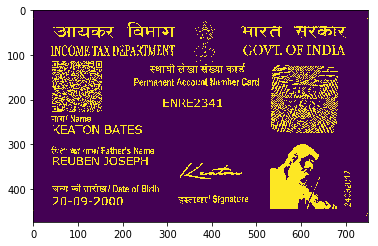

In [105]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu 
import numpy as np
from skimage.segmentation import clear_border
from skimage.morphology import binary_dilation, binary_closing, square

# convert the image to gray
img = rgb2gray(imread("/Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Keaton_Bates.jpg"))

#binarize the image
for_edge_detection_img = np.ones(img.shape)
r,c = img.shape
divider = 2
for ri in range(divider):
    for ci in range(divider):
        region = img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        thresh = threshold_otsu(region)
        for_edge_detection_img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh

plt.imshow(for_edge_detection_img)
plt.show()

In [106]:
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

# label image regions
label_image = label(for_edge_detection_img)
al_areas = []
for region in regionprops(label_image):
    al_areas.append(region.area)

In [107]:
import math
math.floor(math.sqrt(np.median(al_areas)))

2

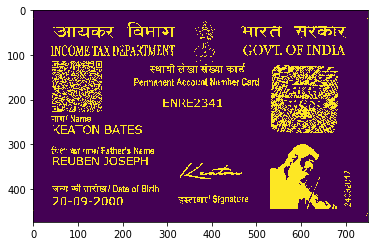

In [108]:
plt.imshow(binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas))))))
plt.show()

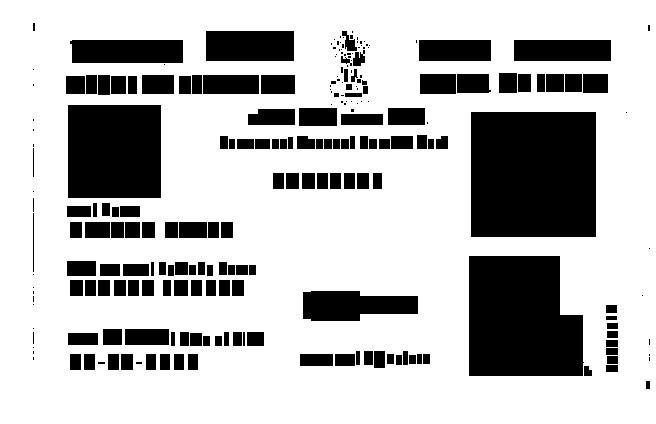

In [109]:
from skimage import img_as_float 

binary_closed = binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas)))))
# label image regions
label_image = label(binary_closed)
fig, ax = plt.subplots(figsize=(10, 6))

image_black = img_as_float(np.ones(img.shape))

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    if region.bbox_area < 0.1 * img.shape[0]*img.shape[1]:
        image_black[minr:maxr, minc:maxc] = 0

ax.imshow(image_black, cmap="gray")
ax.set_axis_off()
plt.tight_layout()
plt.show()

var 0.21599614527872263
var 0.2140362217731411
var 0.18292120663462177
var 0.1904837084299962
var 0.24603914366361548
var 0.17472614694960614
var 0.2212908222368166
var 0.23648328729409374
var 0.224015132736806
var 0.13481527729136594
var 0.14385739562046043
var 0.24217001579355513
var 0.14680641337721284
var 0.12324592247358826
var 0.1920591205734051
var 0.2480615132373616


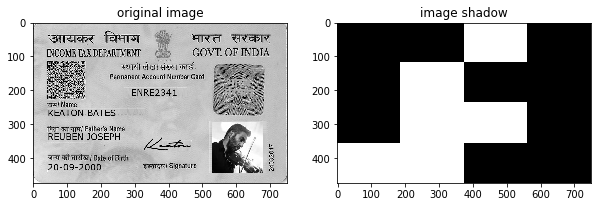

In [125]:
image_black_c = np.copy(image_black)
divider = 4
r, c = image_black_c.shape
for ri in range(divider):
    for ci in range(divider):
        region = image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        region_r, region_c = region.shape
        print("var",np.var(region))
        if np.sum(region)/(region_r*region_c) > 0.75:
            image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = 1.0
        else:
            image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = 0.0


fig, ax = plt.subplots(figsize=(10, 6), ncols=2)
ax[0].set_title("original image")
ax[0].imshow(img, cmap="gray")

ax[1].set_title("image shadow")
ax[1].imshow(image_black_c, cmap="gray")

In [111]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu 
import numpy as np
from skimage.segmentation import clear_border
from skimage.morphology import binary_dilation, binary_closing, square
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import math
# let build a method to return the image mask.
def get_white_space_signature(image, threshold=0.75, decider_indexes=None):
    if len(image.shape) != 2:
        print("must be a gray image.")
        return
    
    # step 1: binarize the image
    binarized_img = np.ones(image.shape) # create a white image
    r, c = image.shape
    
    divider = 2 # threshold 4 regions seperately.
    for ri in range(divider):
        for ci in range(divider):
            region = image[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
            thresh = threshold_otsu(region)
            binarized_img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh
    
    # step 2: identify the median size of bounding box
    label_image = label(binarized_img)
    al_areas = []
    for region in regionprops(label_image):
        al_areas.append(region.area)

    # step 3: binary close the image the size of average bounding box.
    binary_closed = binary_closing(binarized_img, square(math.floor(math.sqrt(np.median(al_areas)))))
    label_image = label(binary_closed)

    image_blank = np.ones((r,c))
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        # consider for cleaning only if the image is less than 10% of the image.
        if region.bbox_area < 0.1 * r*c:
            image_blank[minr:maxr, minc:maxc] = 0

    # step 4: generate the image mask by dividing the image into 16 regions.
    image_signature = []
    divider = 4
    current_index = -1
    for ri in range(divider):
        for ci in range(divider):
            current_index += 1
            if decider_indexes is not None and current_index not in decider_indexes:
                continue #ignore these calculations
                
            region = image_blank[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
            region_r, region_c = region.shape
            
            if np.sum(region)/(region_r*region_c) > threshold:
                image_signature.append(1)
            else:
                image_signature.append(0)

    
    return image_signature

In [112]:
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan1.png"))))
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan2.jpg"))))
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan3.jpeg"))))
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan4.jpeg"))))
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan5.png"))))
# print(get_white_space_signature(rgb2gray(imread("resources/pan/pan6.jpeg"))))

In [113]:
from os import listdir
from os.path import isfile, join
import os  

mypath = '/Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

groups = {}
for file in onlyfiles[0:20]:
    try:
        bin_mask = get_white_space_signature(rgb2gray(imread(join(mypath, file))), decider_indexes=[9,10,11,12,13,14,15])
        print(str(bin_mask))
        
        if str(bin_mask) not in groups:
            groups[str(bin_mask)] = []
        groups[str(bin_mask)].append(file)
        
    except:
        print(file)

var 0.1215089051618116
var 0.1289265304783556
var 0.24984408789862164
var 0.14515418277533015
var 0.12020425297911881
var 0.18428598038236613
var 0.24954730647351736
[1, 1, 0, 1, 1, 1, 0]
var 0.13621846791591527
var 0.17300167261865598
var 0.24886005493639463
var 0.1440454056648102
var 0.12087972688076644
var 0.21462328061694855
var 0.24971452112387038
[1, 1, 0, 1, 1, 0, 0]
var 0.10559725927296716
var 0.14294001764882427
var 0.2496829596942803
var 0.14631501604044628
var 0.1223851162705649
var 0.18903519070970543
var 0.24968984211797787
[1, 1, 0, 1, 1, 0, 0]
var 0.11740474449085242
var 0.14016419960556195
var 0.24885700899235824
var 0.14576442598106645
var 0.129934590404745
var 0.18305922170709582
var 0.24919436592041552
[1, 1, 0, 1, 1, 1, 0]
var 0.13481527729136594
var 0.14385739562046043
var 0.24217001579355513
var 0.14680641337721284
var 0.12324592247358826
var 0.1920591205734051
var 0.2480615132373616
[1, 1, 0, 1, 1, 0, 0]
var 0.1897335568277329
var 0.17512462858616457
var 0.248860

[1, 1, 0, 1, 1, 1, 0] /Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Oleg_Reed.jpg
[1, 1, 0, 1, 1, 0, 0] /Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Raphael_Roy.jpg
[0, 1, 0, 1, 1, 0, 0] /Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Forrest_Salazar.jpg
[1, 1, 1, 1, 1, 1, 1] /Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Jermaine_Tran.jpg


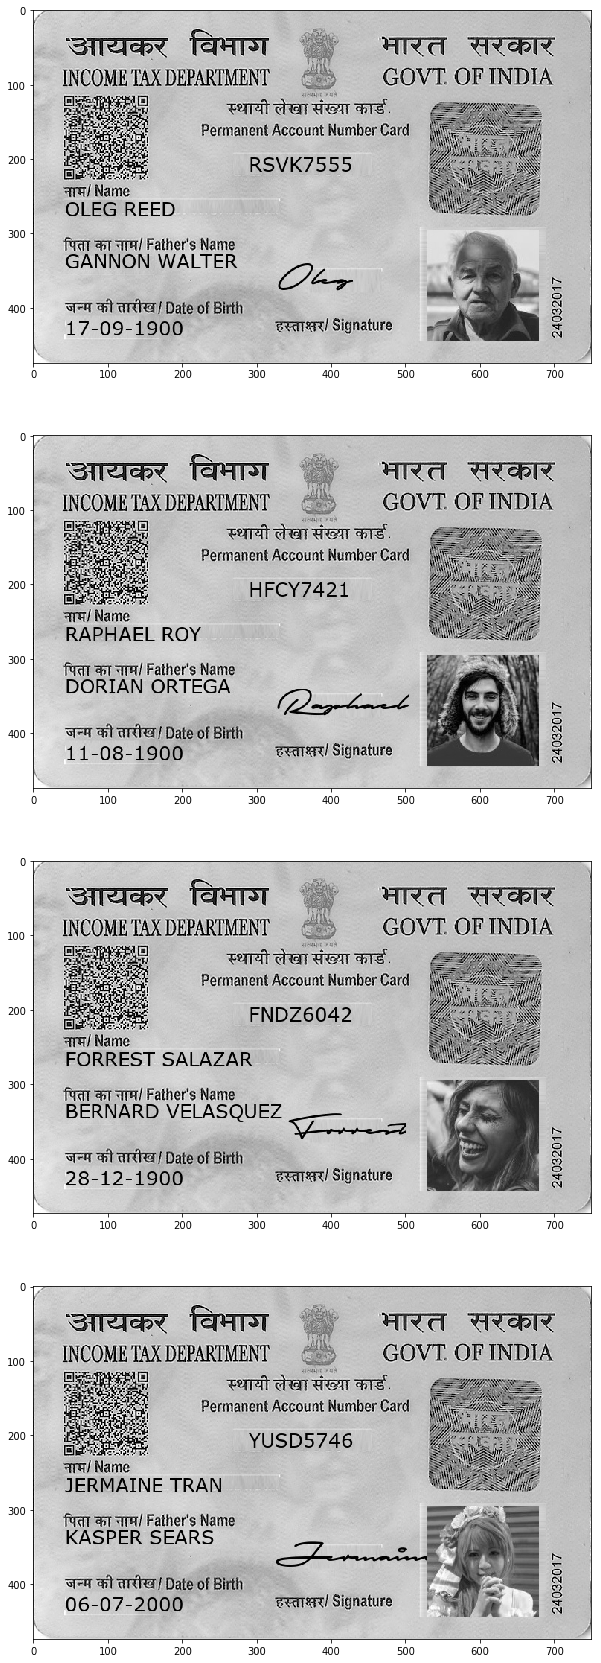

In [114]:
fig, ax = plt.subplots(nrows=len(groups), figsize=(10,30))
i = 0
for key in groups:
    print(key, join(mypath,groups[key][0]))
    ax[i].imshow(rgb2gray(imread(join(mypath,groups[key][0]))), cmap="gray")
    i+=1

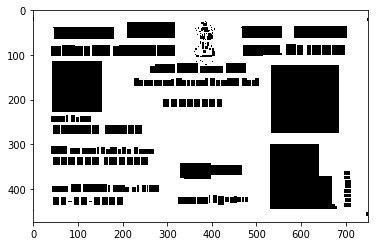

In [121]:
plt.imshow(image_black, cmap="gray")

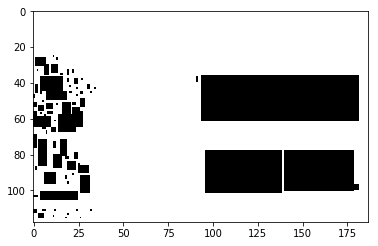

In [123]:
sample = rgb2gray(imread("/Users/muthukrishnan/programming/ml_research/resources/dummy_pans/pan_new/Keaton_Bates.jpg"))
r, c = sample.shape
divider = 4
ri = 0
ci = 2
region = image_black[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
plt.imshow(region, cmap="gray")